## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


2 Physical GPUs 2 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
num devices = 2


### Prep MNIST data

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

        self.enc_log_var = tfk.Sequential(
                [   tfkl.Dense(style_dim, activation=tf.math.softplus)
                    ],
                    name="z_log_var",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
        z_log_var = self.enc_log_var(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        z_log_var = tfkl.Reshape((ninstances, self.style_dim))(z_log_var)
        
        return z_mean, z_log_var
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \sum( p(xi)*\mu(xi) )/ \sum(p(xi)), 1/\sum(p(xi)) ) where
    p(xi) is the precision of the ith instance.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="enc_mean",
                )

        self.enc_precision = tfk.Sequential(
                [   tfkl.Dense(content_dim, activation=tf.math.softplus)
                    ],
                    name="enc_precision",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        enc_mean = self.enc_mean(common) # [?*instances, content_dim]
        enc_precision = self.enc_precision(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        enc_mean = tfkl.Reshape((ninstances, self.content_dim))(enc_mean)
        enc_precision = tfkl.Reshape((ninstances, self.content_dim))(enc_precision)
        
        # compute average precision: [?, content_dim]
        avg_precision = tfkl.GlobalAveragePooling1D()(enc_precision)
        z_log_var = tf.math.log(1./avg_precision)
        
        # compute weighted average of means
        z_mean = enc_precision*enc_mean # [?, instances, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean) # [?, content_dim]
        
        z_mean = z_mean/avg_precision # [?, content_dim]
                
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        z_log_var = tfkl.Reshape((1, self.content_dim))(z_log_var)
        
        return z_mean, z_log_var

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim, dec_var_model='trainable',
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
        
        self.dec_var_model = dec_var_model

#         trainable = True if dec_var_model=='trainable' else False
        self.dec_var = tf.Variable(
                initial_value= tf.constant(1.0, dtype='float32'),
                name='dec_var',
                trainable= True if dec_var_model=='trainable' else False,
#                 trainable=trainable,
                )
        
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        x_var = self.dec_var

        return x_mean, x_var
    
class Sampler(tfkl.Layer):
    """ Samples from Normal with z_mean and z_log_var.

    Returns  (-1, z_mean.shape[0], nsamp)
    """
    def __init__(self, nsamp=1, name='sampler', **kwargs):
        super().__init__(name=name, **kwargs)

        if nsamp > 1:
            raise NotImplementedError

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tfk.backend.random_normal(shape=tf.shape(z_mean))

        return z_mean + 0.5*tf.exp(z_log_var)*epsilon

class MLVAE(tfk.Model):
    """ Multilevel Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)
        
        self.dec_var_model = dec_var_model

        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim, dec_var_model=dec_var_model)
        
        self.sampler = Sampler()

    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
        cnt_log_var_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_log_var)
        
        # sample
        z_sty = self.sampler( (sty_mean, sty_log_var) ) # [?, instances, style_dim]
        z_cnt = self.sampler( (cnt_mean_replicate, cnt_log_var_replicate) ) # [?, instances, content_dim]
        
        # concatenate
        z = tfkl.Concatenate(axis=-1)([z_sty, z_cnt])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
        
        log_llhd_per_ex = (1/dec_var)*se_per_ex + ninstances*tf.math.log(dec_var)
        log_llhd_per_ex = -0.5*log_llhd_per_ex # [?,], we 'max' the ELBO        
        
        sty_KL = -sty_log_var + tf.exp(sty_log_var) + tf.square(sty_mean) # [?, instances, style_dim]
        sty_KL_per_instance = tf.reduce_sum(sty_KL, axis=-1) # [?, instances]
        sty_KL_per_ex = 0.5*tf.reduce_sum(sty_KL_per_instance, axis=-1) # [?, ]
        
        cnt_mean = cnt_mean[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_log_var = cnt_log_var[:,0,:] #[?, 1, content_dim] -> [?, content_dim]
        cnt_KL = -cnt_log_var + tf.exp(cnt_log_var) + tf.square(cnt_mean) #[?, content_dim]
        cnt_KL_per_ex = 0.5*tf.reduce_sum(cnt_KL, axis=-1) #[?, ]
        
        ELBO_per_ex = log_llhd_per_ex - sty_KL_per_ex - cnt_KL_per_ex # [?, ]
        
        return ELBO_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean, dec_var = self.decoder(z)

        return dec_mean
  
    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean, cnt_log_var = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean, sty_log_var = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean, _ = self.decoder(z)
        
        return dec_mean

    def decode(self, z):
        """ Apply decoder to arbitrary input """
        x_dec, x_var = self.decoder(z)

        return x_dec, x_var

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    ninstances = NUM_INSTANCES
    
    mlvae = MLVAE(data_dim, style_dim, content_dim, dec_var_model='fixed')
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        elbo_per_ex, log_llhd_per_ex, sty_KL_per_ex, cnt_KL_per_ex, mse_per_ex, x_mean = mlvae(inputs)

        # compute average loss using batch size
        elbo = tf.nn.compute_average_loss(elbo_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        loss = -elbo
        
    # track metrics
    trn_loss_metric(-elbo_per_ex)
    trn_mse_metric(mse_per_ex)
    trn_sty_KL_metric(sty_KL_per_ex)
    trn_cnt_KL_metric(cnt_KL_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, mlvae.trainable_weights)
    opt.apply_gradients(zip(grads, mlvae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

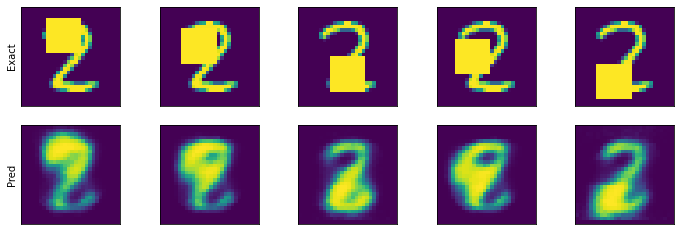

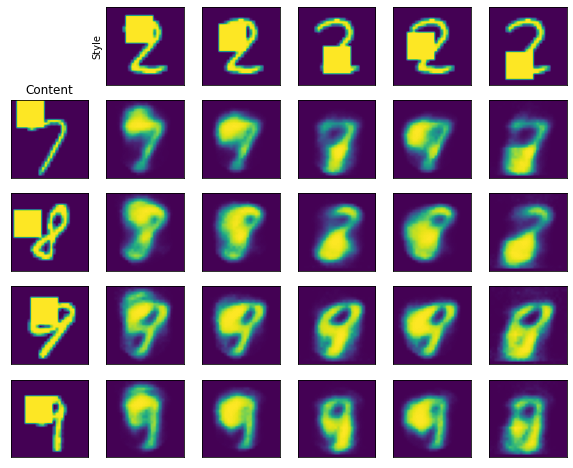

	mean loss    = 878.324
	mse          = 1.168e+03
	KL           = 2.669e+02
	KL           = 2.720e+01
	dec_var      = 1.000e+00
epoch = 62.11s
Start of epoch 1
	mean loss    = 658.207
	mse          = 7.003e+02
	KL           = 2.847e+02
	KL           = 2.336e+01
	dec_var      = 1.000e+00
epoch = 51.03s
Start of epoch 2
	mean loss    = 615.520
	mse          = 6.113e+02
	KL           = 2.863e+02
	KL           = 2.355e+01
	dec_var      = 1.000e+00
epoch = 53.58s
Start of epoch 3
	mean loss    = 591.143
	mse          = 5.589e+02
	KL           = 2.878e+02
	KL           = 2.392e+01
	dec_var      = 1.000e+00
epoch = 50.79s
Start of epoch 4
	mean loss    = 574.139
	mse          = 5.213e+02
	KL           = 2.893e+02
	KL           = 2.424e+01
	dec_var      = 1.000e+00
epoch = 49.78s
Start of epoch 5
=== TRN ===


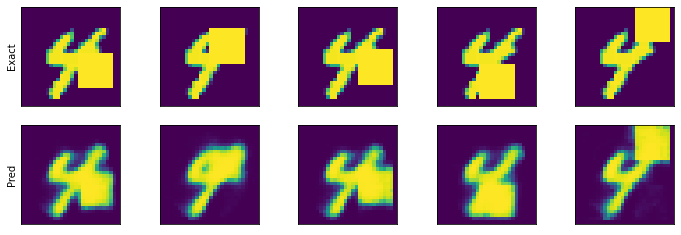

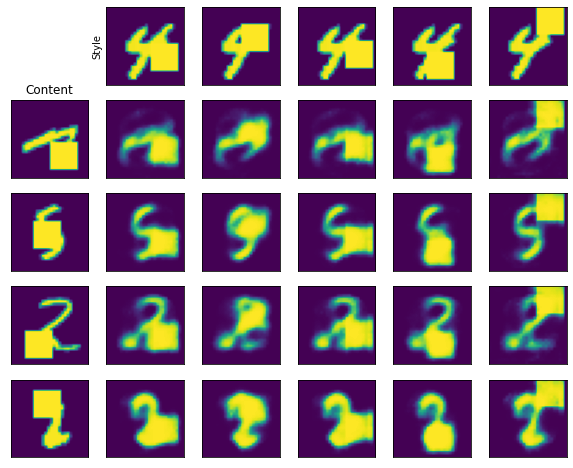

	mean loss    = 559.620
	mse          = 4.894e+02
	KL           = 2.904e+02
	KL           = 2.456e+01
	dec_var      = 1.000e+00
epoch = 50.44s
Start of epoch 6
	mean loss    = 548.335
	mse          = 4.644e+02
	KL           = 2.914e+02
	KL           = 2.476e+01
	dec_var      = 1.000e+00
epoch = 48.97s
Start of epoch 7
	mean loss    = 538.289
	mse          = 4.425e+02
	KL           = 2.921e+02
	KL           = 2.493e+01
	dec_var      = 1.000e+00
epoch = 49.48s
Start of epoch 8
	mean loss    = 530.069
	mse          = 4.247e+02
	KL           = 2.927e+02
	KL           = 2.503e+01
	dec_var      = 1.000e+00
epoch = 49.00s
Start of epoch 9
	mean loss    = 523.353
	mse          = 4.103e+02
	KL           = 2.931e+02
	KL           = 2.509e+01
	dec_var      = 1.000e+00
epoch = 48.37s
Start of epoch 10
=== TRN ===


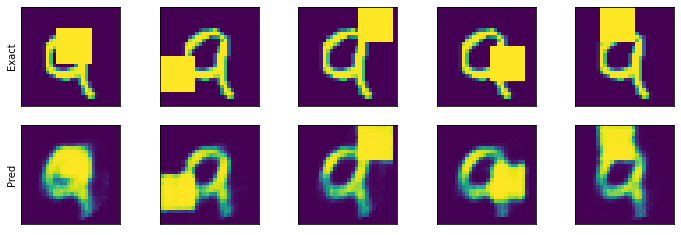

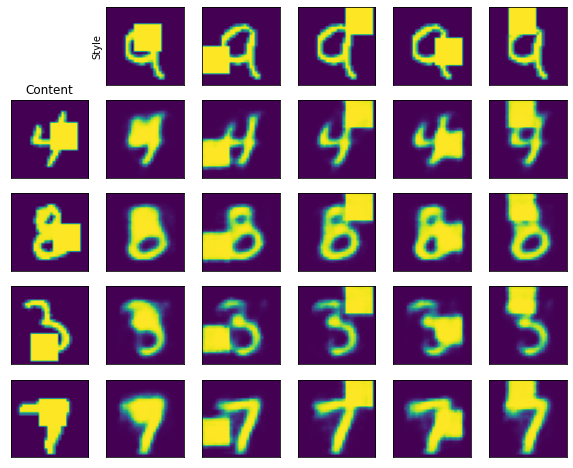

	mean loss    = 517.418
	mse          = 3.977e+02
	KL           = 2.934e+02
	KL           = 2.515e+01
	dec_var      = 1.000e+00
epoch = 49.94s
Start of epoch 11
	mean loss    = 512.369
	mse          = 3.869e+02
	KL           = 2.937e+02
	KL           = 2.520e+01
	dec_var      = 1.000e+00
epoch = 47.71s
Start of epoch 12
	mean loss    = 507.883
	mse          = 3.775e+02
	KL           = 2.939e+02
	KL           = 2.524e+01
	dec_var      = 1.000e+00
epoch = 46.87s
Start of epoch 13
	mean loss    = 503.904
	mse          = 3.691e+02
	KL           = 2.941e+02
	KL           = 2.527e+01
	dec_var      = 1.000e+00
epoch = 47.58s
Start of epoch 14
	mean loss    = 500.451
	mse          = 3.617e+02
	KL           = 2.943e+02
	KL           = 2.531e+01
	dec_var      = 1.000e+00
epoch = 46.87s
Start of epoch 15
=== TRN ===


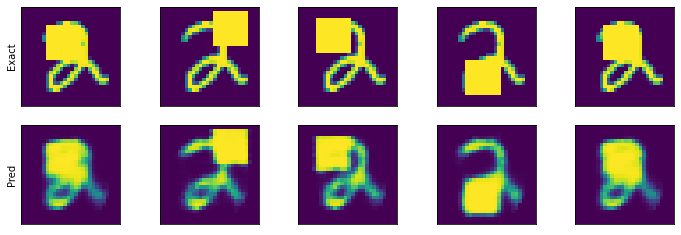

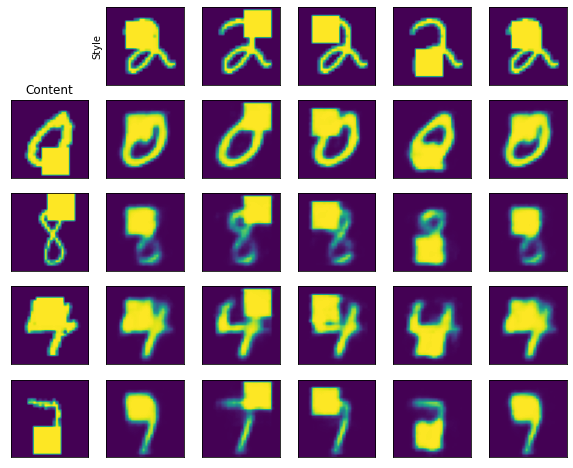

	mean loss    = 497.111
	mse          = 3.548e+02
	KL           = 2.944e+02
	KL           = 2.533e+01
	dec_var      = 1.000e+00
epoch = 48.31s
Start of epoch 16
	mean loss    = 494.208
	mse          = 3.488e+02
	KL           = 2.945e+02
	KL           = 2.535e+01
	dec_var      = 1.000e+00
epoch = 47.05s
Start of epoch 17
	mean loss    = 491.633
	mse          = 3.432e+02
	KL           = 2.946e+02
	KL           = 2.537e+01
	dec_var      = 1.000e+00
epoch = 47.62s
Start of epoch 18
	mean loss    = 489.293
	mse          = 3.384e+02
	KL           = 2.947e+02
	KL           = 2.539e+01
	dec_var      = 1.000e+00
epoch = 48.46s
Start of epoch 19
	mean loss    = 487.014
	mse          = 3.336e+02
	KL           = 2.948e+02
	KL           = 2.541e+01
	dec_var      = 1.000e+00
epoch = 47.15s
Start of epoch 20
=== TRN ===


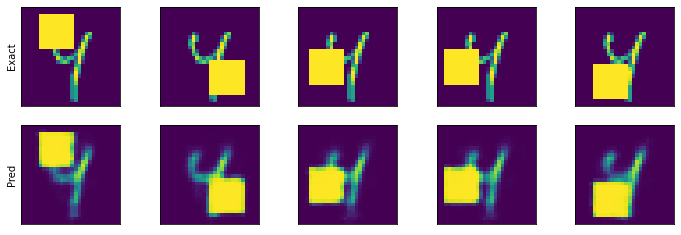

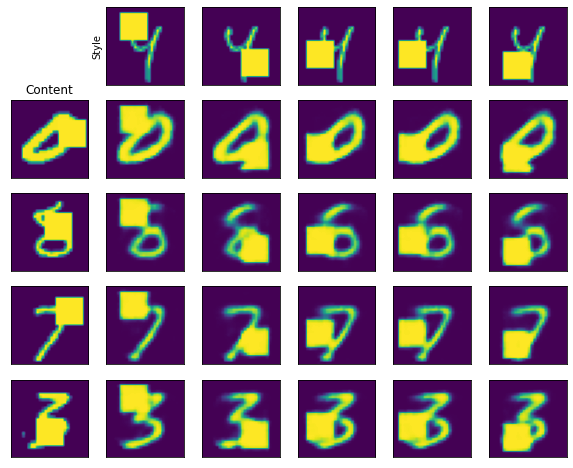

	mean loss    = 484.844
	mse          = 3.294e+02
	KL           = 2.947e+02
	KL           = 2.543e+01
	dec_var      = 1.000e+00
epoch = 49.13s
Start of epoch 21
	mean loss    = 483.136
	mse          = 3.256e+02
	KL           = 2.949e+02
	KL           = 2.544e+01
	dec_var      = 1.000e+00
epoch = 47.33s
Start of epoch 22
	mean loss    = 481.693
	mse          = 3.223e+02
	KL           = 2.951e+02
	KL           = 2.546e+01
	dec_var      = 1.000e+00
epoch = 47.31s
Start of epoch 23
	mean loss    = 479.991
	mse          = 3.188e+02
	KL           = 2.951e+02
	KL           = 2.547e+01
	dec_var      = 1.000e+00
epoch = 47.58s
Start of epoch 24
	mean loss    = 478.483
	mse          = 3.157e+02
	KL           = 2.952e+02
	KL           = 2.548e+01
	dec_var      = 1.000e+00
epoch = 47.45s
Start of epoch 25
=== TRN ===


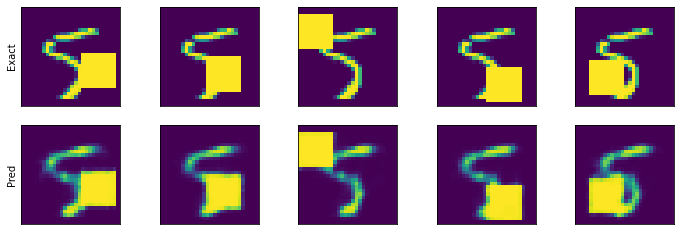

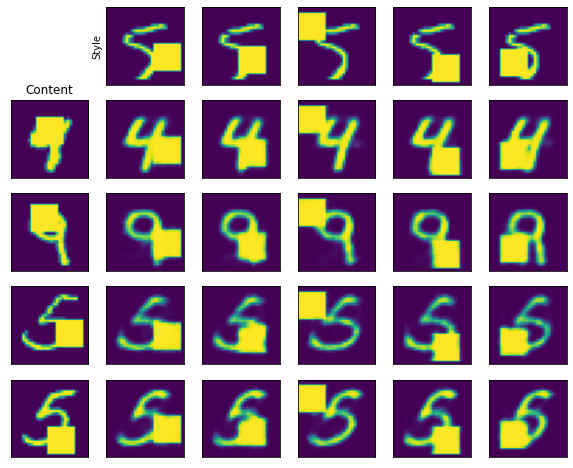

	mean loss    = 477.095
	mse          = 3.127e+02
	KL           = 2.952e+02
	KL           = 2.550e+01
	dec_var      = 1.000e+00
epoch = 49.28s
Start of epoch 26
	mean loss    = 475.753
	mse          = 3.099e+02
	KL           = 2.953e+02
	KL           = 2.551e+01
	dec_var      = 1.000e+00
epoch = 48.15s
Start of epoch 27
	mean loss    = 474.716
	mse          = 3.077e+02
	KL           = 2.953e+02
	KL           = 2.552e+01
	dec_var      = 1.000e+00
epoch = 47.54s
Start of epoch 28
	mean loss    = 473.505
	mse          = 3.050e+02
	KL           = 2.954e+02
	KL           = 2.554e+01
	dec_var      = 1.000e+00
epoch = 48.07s
Start of epoch 29
	mean loss    = 472.271
	mse          = 3.028e+02
	KL           = 2.953e+02
	KL           = 2.555e+01
	dec_var      = 1.000e+00
epoch = 47.74s
Start of epoch 30
=== TRN ===


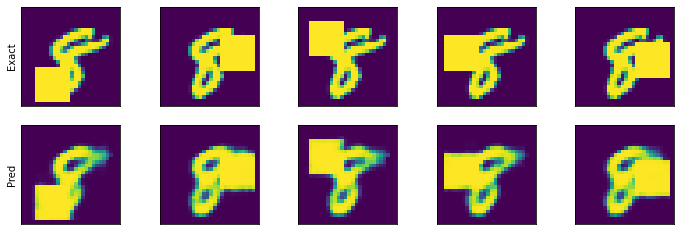

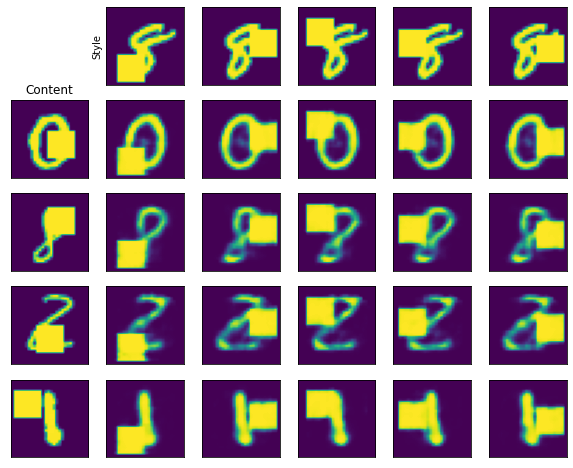

	mean loss    = 471.316
	mse          = 3.006e+02
	KL           = 2.954e+02
	KL           = 2.555e+01
	dec_var      = 1.000e+00
epoch = 49.87s
Start of epoch 31
	mean loss    = 470.345
	mse          = 2.984e+02
	KL           = 2.955e+02
	KL           = 2.557e+01
	dec_var      = 1.000e+00
epoch = 47.29s
Start of epoch 32
	mean loss    = 469.326
	mse          = 2.965e+02
	KL           = 2.955e+02
	KL           = 2.558e+01
	dec_var      = 1.000e+00
epoch = 47.40s
Start of epoch 33
	mean loss    = 468.666
	mse          = 2.948e+02
	KL           = 2.957e+02
	KL           = 2.560e+01
	dec_var      = 1.000e+00
epoch = 47.51s
Start of epoch 34
	mean loss    = 467.682
	mse          = 2.929e+02
	KL           = 2.956e+02
	KL           = 2.561e+01
	dec_var      = 1.000e+00
epoch = 48.07s
Start of epoch 35
=== TRN ===


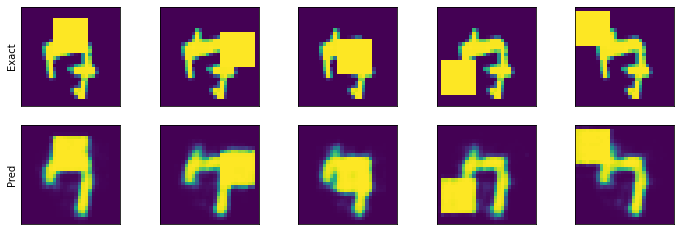

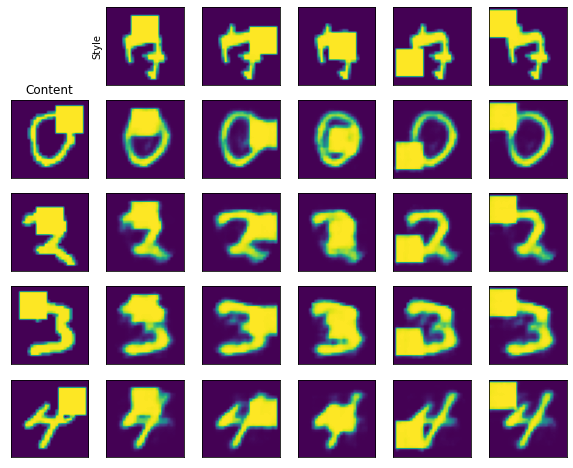

	mean loss    = 467.008
	mse          = 2.914e+02
	KL           = 2.957e+02
	KL           = 2.561e+01
	dec_var      = 1.000e+00
epoch = 47.80s
Start of epoch 36
	mean loss    = 466.086
	mse          = 2.895e+02
	KL           = 2.957e+02
	KL           = 2.562e+01
	dec_var      = 1.000e+00
epoch = 47.28s
Start of epoch 37
	mean loss    = 465.483
	mse          = 2.882e+02
	KL           = 2.958e+02
	KL           = 2.564e+01
	dec_var      = 1.000e+00
epoch = 47.47s
Start of epoch 38
	mean loss    = 464.782
	mse          = 2.867e+02
	KL           = 2.958e+02
	KL           = 2.564e+01
	dec_var      = 1.000e+00
epoch = 47.86s
Start of epoch 39
	mean loss    = 464.217
	mse          = 2.853e+02
	KL           = 2.959e+02
	KL           = 2.566e+01
	dec_var      = 1.000e+00
epoch = 46.41s
Start of epoch 40
=== TRN ===


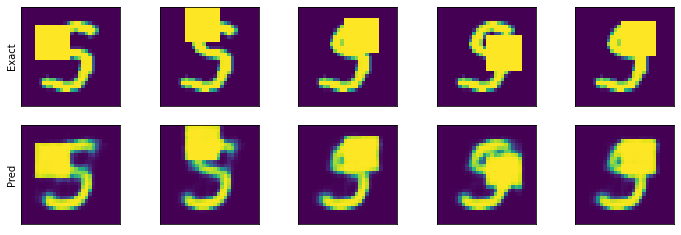

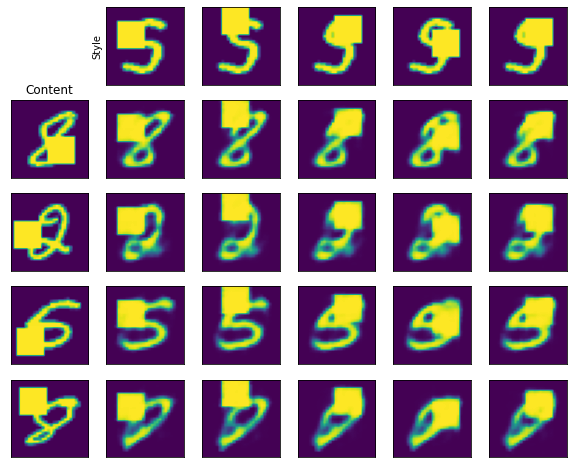

	mean loss    = 463.502
	mse          = 2.839e+02
	KL           = 2.959e+02
	KL           = 2.566e+01
	dec_var      = 1.000e+00
epoch = 48.87s
Start of epoch 41
	mean loss    = 462.825
	mse          = 2.825e+02
	KL           = 2.959e+02
	KL           = 2.567e+01
	dec_var      = 1.000e+00
epoch = 47.75s
Start of epoch 42
	mean loss    = 462.282
	mse          = 2.813e+02
	KL           = 2.959e+02
	KL           = 2.568e+01
	dec_var      = 1.000e+00
epoch = 45.84s
Start of epoch 43
	mean loss    = 461.739
	mse          = 2.802e+02
	KL           = 2.960e+02
	KL           = 2.570e+01
	dec_var      = 1.000e+00
epoch = 47.69s
Start of epoch 44
	mean loss    = 461.179
	mse          = 2.790e+02
	KL           = 2.960e+02
	KL           = 2.570e+01
	dec_var      = 1.000e+00
epoch = 47.68s
Start of epoch 45
=== TRN ===


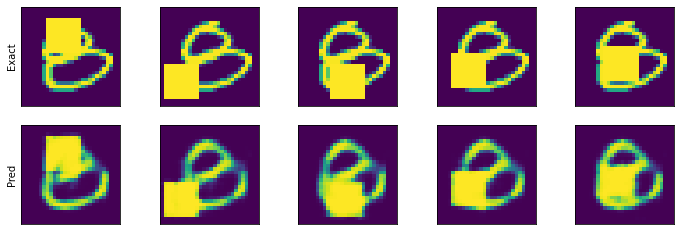

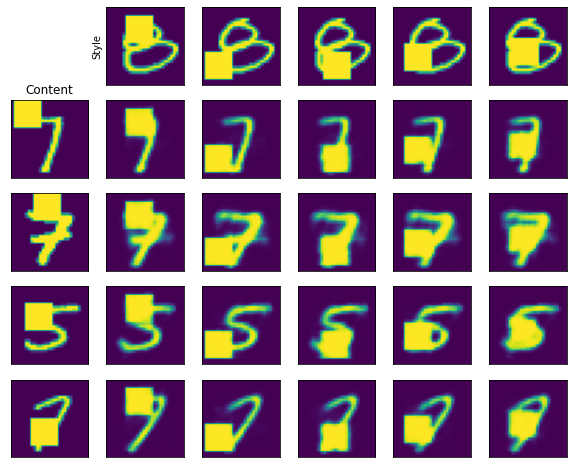

	mean loss    = 460.552
	mse          = 2.777e+02
	KL           = 2.960e+02
	KL           = 2.571e+01
	dec_var      = 1.000e+00
epoch = 49.97s
Start of epoch 46
	mean loss    = 460.142
	mse          = 2.768e+02
	KL           = 2.960e+02
	KL           = 2.571e+01
	dec_var      = 1.000e+00
epoch = 47.55s
Start of epoch 47
	mean loss    = 459.688
	mse          = 2.758e+02
	KL           = 2.961e+02
	KL           = 2.573e+01
	dec_var      = 1.000e+00
epoch = 48.28s
Start of epoch 48
	mean loss    = 459.187
	mse          = 2.747e+02
	KL           = 2.961e+02
	KL           = 2.574e+01
	dec_var      = 1.000e+00
epoch = 47.08s
Start of epoch 49
	mean loss    = 458.658
	mse          = 2.737e+02
	KL           = 2.961e+02
	KL           = 2.574e+01
	dec_var      = 1.000e+00
epoch = 48.10s
Start of epoch 50
=== TRN ===


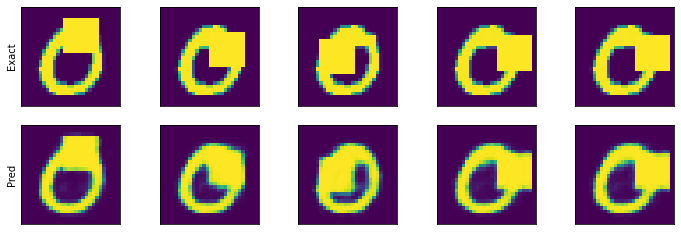

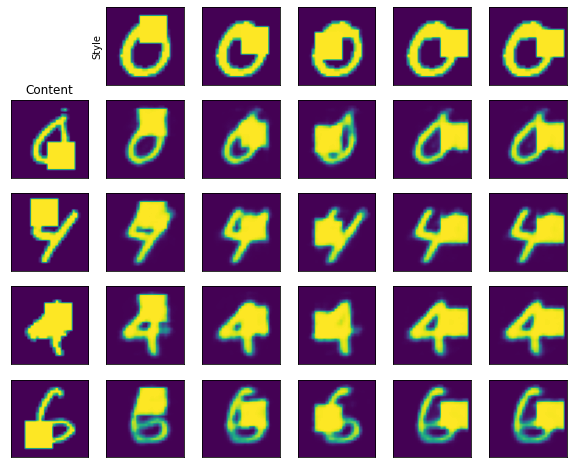

	mean loss    = 458.419
	mse          = 2.729e+02
	KL           = 2.962e+02
	KL           = 2.576e+01
	dec_var      = 1.000e+00
epoch = 49.95s
Start of epoch 51
	mean loss    = 457.877
	mse          = 2.719e+02
	KL           = 2.962e+02
	KL           = 2.576e+01
	dec_var      = 1.000e+00
epoch = 48.20s
Start of epoch 52
	mean loss    = 457.562
	mse          = 2.711e+02
	KL           = 2.962e+02
	KL           = 2.577e+01
	dec_var      = 1.000e+00
epoch = 46.55s
Start of epoch 53
	mean loss    = 457.057
	mse          = 2.701e+02
	KL           = 2.962e+02
	KL           = 2.576e+01
	dec_var      = 1.000e+00
epoch = 47.48s
Start of epoch 54
	mean loss    = 456.766
	mse          = 2.694e+02
	KL           = 2.963e+02
	KL           = 2.578e+01
	dec_var      = 1.000e+00
epoch = 49.37s
Start of epoch 55
=== TRN ===


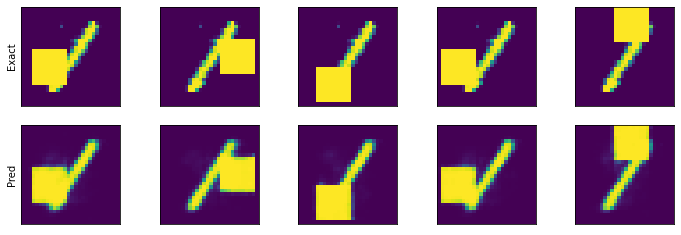

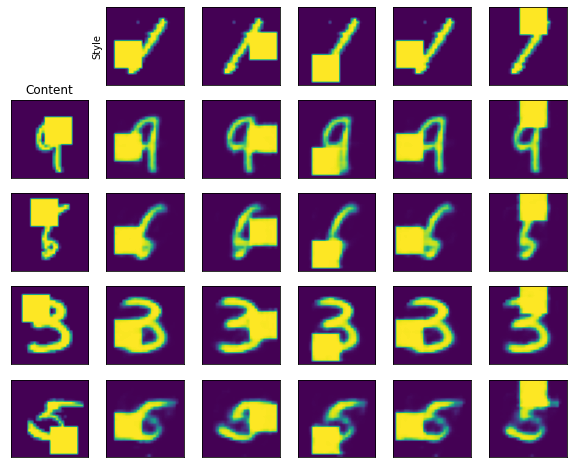

	mean loss    = 456.243
	mse          = 2.685e+02
	KL           = 2.962e+02
	KL           = 2.579e+01
	dec_var      = 1.000e+00
epoch = 49.54s
Start of epoch 56
	mean loss    = 456.018
	mse          = 2.678e+02
	KL           = 2.963e+02
	KL           = 2.579e+01
	dec_var      = 1.000e+00
epoch = 47.15s
Start of epoch 57
	mean loss    = 455.673
	mse          = 2.671e+02
	KL           = 2.963e+02
	KL           = 2.580e+01
	dec_var      = 1.000e+00
epoch = 47.03s
Start of epoch 58
	mean loss    = 455.321
	mse          = 2.664e+02
	KL           = 2.963e+02
	KL           = 2.580e+01
	dec_var      = 1.000e+00
epoch = 48.14s
Start of epoch 59
	mean loss    = 454.919
	mse          = 2.657e+02
	KL           = 2.963e+02
	KL           = 2.580e+01
	dec_var      = 1.000e+00
epoch = 47.69s
Start of epoch 60
=== TRN ===


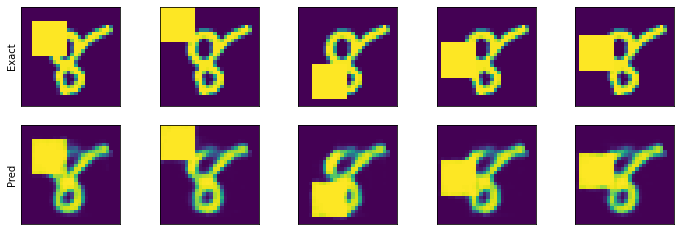

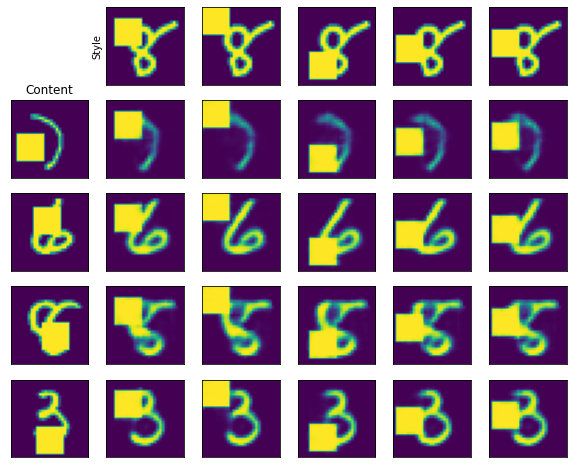

	mean loss    = 454.543
	mse          = 2.648e+02
	KL           = 2.963e+02
	KL           = 2.581e+01
	dec_var      = 1.000e+00
epoch = 48.65s
Start of epoch 61
	mean loss    = 454.402
	mse          = 2.644e+02
	KL           = 2.964e+02
	KL           = 2.582e+01
	dec_var      = 1.000e+00
epoch = 47.83s
Start of epoch 62
	mean loss    = 454.025
	mse          = 2.637e+02
	KL           = 2.963e+02
	KL           = 2.582e+01
	dec_var      = 1.000e+00
epoch = 47.15s
Start of epoch 63
	mean loss    = 453.802
	mse          = 2.631e+02
	KL           = 2.964e+02
	KL           = 2.583e+01
	dec_var      = 1.000e+00
epoch = 48.49s
Start of epoch 64
	mean loss    = 453.462
	mse          = 2.624e+02
	KL           = 2.964e+02
	KL           = 2.584e+01
	dec_var      = 1.000e+00
epoch = 47.76s
Start of epoch 65
=== TRN ===


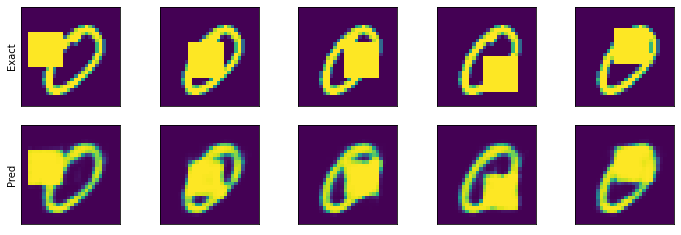

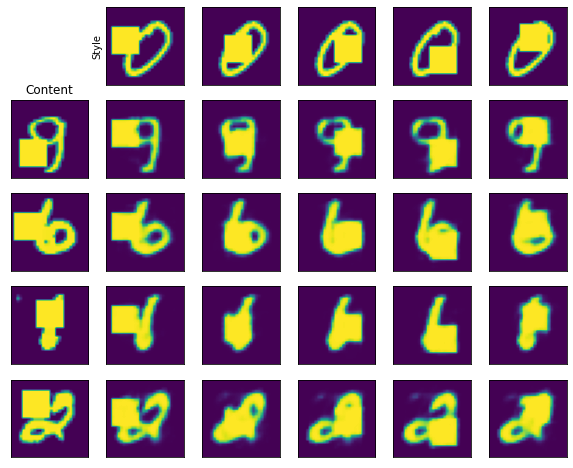

	mean loss    = 453.237
	mse          = 2.620e+02
	KL           = 2.964e+02
	KL           = 2.584e+01
	dec_var      = 1.000e+00
epoch = 49.50s
Start of epoch 66
	mean loss    = 452.861
	mse          = 2.613e+02
	KL           = 2.964e+02
	KL           = 2.584e+01
	dec_var      = 1.000e+00
epoch = 46.59s
Start of epoch 67
	mean loss    = 452.615
	mse          = 2.607e+02
	KL           = 2.964e+02
	KL           = 2.585e+01
	dec_var      = 1.000e+00
epoch = 47.43s
Start of epoch 68
	mean loss    = 452.310
	mse          = 2.601e+02
	KL           = 2.964e+02
	KL           = 2.586e+01
	dec_var      = 1.000e+00
epoch = 47.82s
Start of epoch 69
	mean loss    = 452.088
	mse          = 2.596e+02
	KL           = 2.964e+02
	KL           = 2.586e+01
	dec_var      = 1.000e+00
epoch = 46.75s
Start of epoch 70
=== TRN ===


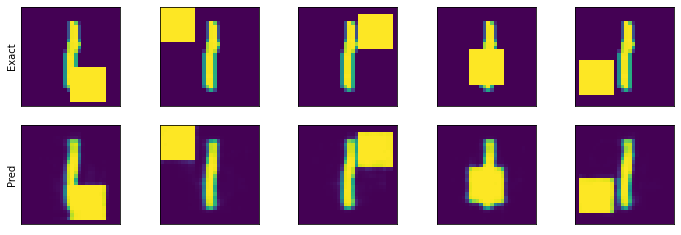

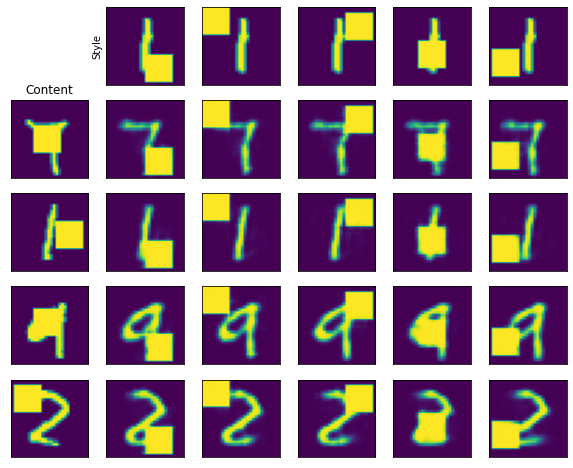

	mean loss    = 451.917
	mse          = 2.591e+02
	KL           = 2.965e+02
	KL           = 2.587e+01
	dec_var      = 1.000e+00
epoch = 50.04s
Start of epoch 71
	mean loss    = 451.751
	mse          = 2.587e+02
	KL           = 2.965e+02
	KL           = 2.588e+01
	dec_var      = 1.000e+00
epoch = 47.70s
Start of epoch 72
	mean loss    = 451.468
	mse          = 2.582e+02
	KL           = 2.965e+02
	KL           = 2.587e+01
	dec_var      = 1.000e+00
epoch = 47.33s
Start of epoch 73
	mean loss    = 451.134
	mse          = 2.576e+02
	KL           = 2.965e+02
	KL           = 2.588e+01
	dec_var      = 1.000e+00
epoch = 48.21s
Start of epoch 74
	mean loss    = 450.973
	mse          = 2.572e+02
	KL           = 2.965e+02
	KL           = 2.588e+01
	dec_var      = 1.000e+00
epoch = 47.02s
Start of epoch 75
=== TRN ===


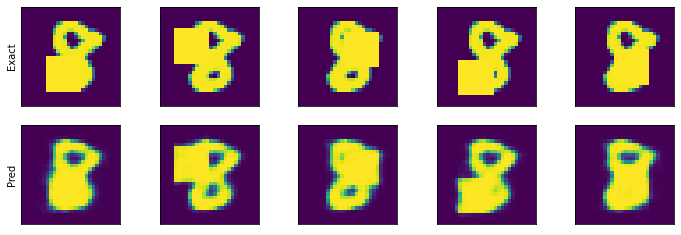

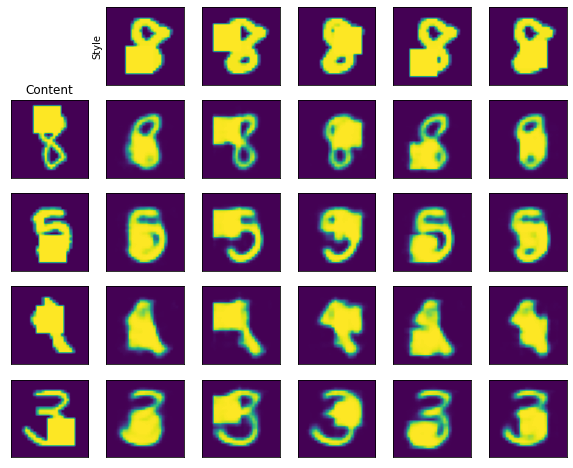

	mean loss    = 450.889
	mse          = 2.568e+02
	KL           = 2.966e+02
	KL           = 2.589e+01
	dec_var      = 1.000e+00
epoch = 49.18s
Start of epoch 76
	mean loss    = 450.676
	mse          = 2.564e+02
	KL           = 2.966e+02
	KL           = 2.589e+01
	dec_var      = 1.000e+00
epoch = 46.79s
Start of epoch 77
	mean loss    = 450.394
	mse          = 2.559e+02
	KL           = 2.965e+02
	KL           = 2.590e+01
	dec_var      = 1.000e+00
epoch = 47.78s
Start of epoch 78
	mean loss    = 450.147
	mse          = 2.554e+02
	KL           = 2.966e+02
	KL           = 2.590e+01
	dec_var      = 1.000e+00
epoch = 47.43s
Start of epoch 79
	mean loss    = 449.985
	mse          = 2.550e+02
	KL           = 2.966e+02
	KL           = 2.590e+01
	dec_var      = 1.000e+00
epoch = 47.39s
Start of epoch 80
=== TRN ===


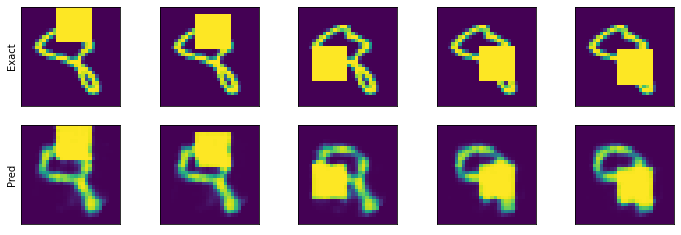

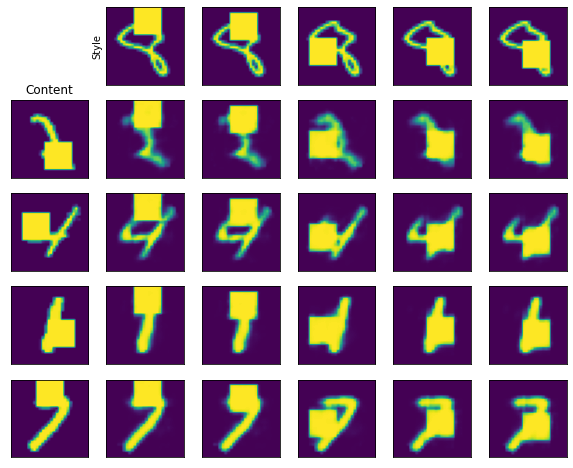

	mean loss    = 449.848
	mse          = 2.547e+02
	KL           = 2.966e+02
	KL           = 2.591e+01
	dec_var      = 1.000e+00
epoch = 48.70s
Start of epoch 81
	mean loss    = 449.657
	mse          = 2.543e+02
	KL           = 2.966e+02
	KL           = 2.592e+01
	dec_var      = 1.000e+00
epoch = 46.80s
Start of epoch 82
	mean loss    = 449.355
	mse          = 2.537e+02
	KL           = 2.966e+02
	KL           = 2.591e+01
	dec_var      = 1.000e+00
epoch = 48.21s
Start of epoch 83
	mean loss    = 449.309
	mse          = 2.534e+02
	KL           = 2.967e+02
	KL           = 2.592e+01
	dec_var      = 1.000e+00
epoch = 47.67s
Start of epoch 84
	mean loss    = 449.069
	mse          = 2.530e+02
	KL           = 2.966e+02
	KL           = 2.593e+01
	dec_var      = 1.000e+00
epoch = 47.86s
Start of epoch 85
=== TRN ===


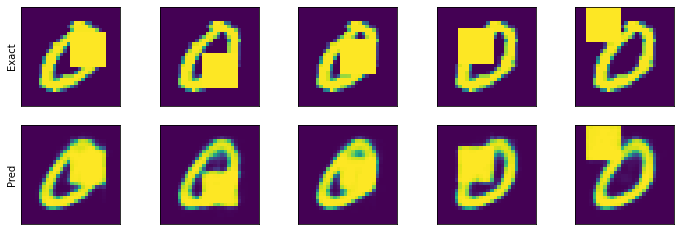

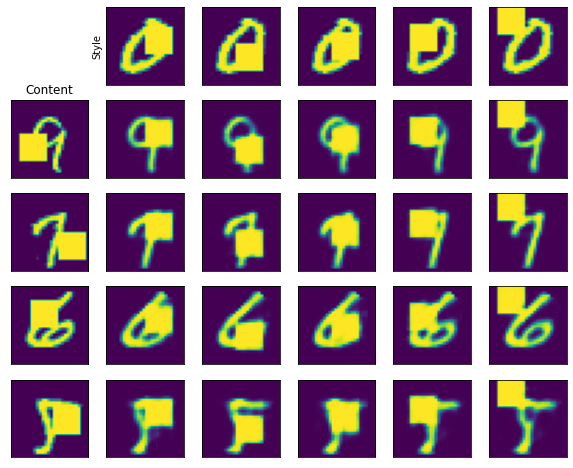

	mean loss    = 448.940
	mse          = 2.528e+02
	KL           = 2.966e+02
	KL           = 2.593e+01
	dec_var      = 1.000e+00
epoch = 48.92s
Start of epoch 86
	mean loss    = 448.981
	mse          = 2.527e+02
	KL           = 2.967e+02
	KL           = 2.594e+01
	dec_var      = 1.000e+00
epoch = 47.90s
Start of epoch 87
	mean loss    = 448.546
	mse          = 2.520e+02
	KL           = 2.966e+02
	KL           = 2.593e+01
	dec_var      = 1.000e+00
epoch = 47.23s
Start of epoch 88
	mean loss    = 448.549
	mse          = 2.519e+02
	KL           = 2.966e+02
	KL           = 2.594e+01
	dec_var      = 1.000e+00
epoch = 46.66s
Start of epoch 89
	mean loss    = 448.416
	mse          = 2.516e+02
	KL           = 2.967e+02
	KL           = 2.595e+01
	dec_var      = 1.000e+00
epoch = 45.74s
Start of epoch 90
=== TRN ===


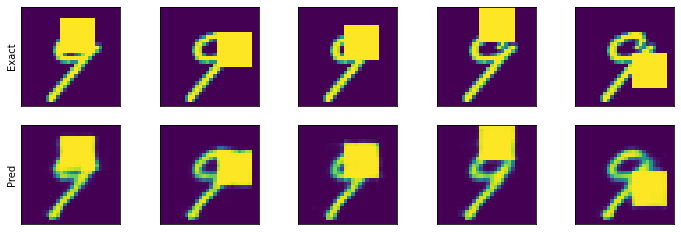

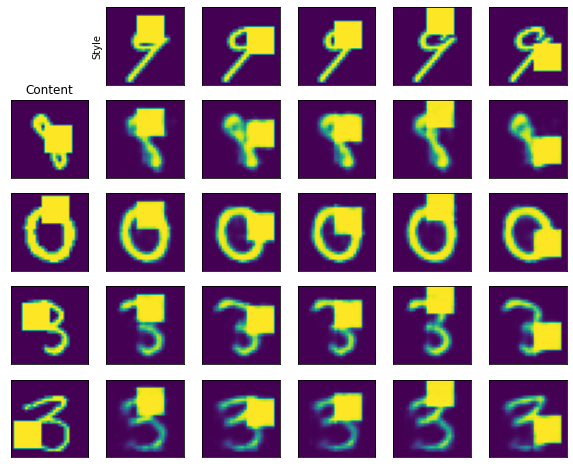

	mean loss    = 448.308
	mse          = 2.513e+02
	KL           = 2.967e+02
	KL           = 2.595e+01
	dec_var      = 1.000e+00
epoch = 47.61s
Start of epoch 91
	mean loss    = 447.961
	mse          = 2.507e+02
	KL           = 2.967e+02
	KL           = 2.595e+01
	dec_var      = 1.000e+00
epoch = 46.68s
Start of epoch 92
	mean loss    = 447.871
	mse          = 2.505e+02
	KL           = 2.967e+02
	KL           = 2.596e+01
	dec_var      = 1.000e+00
epoch = 47.86s
Start of epoch 93
	mean loss    = 447.800
	mse          = 2.502e+02
	KL           = 2.967e+02
	KL           = 2.596e+01
	dec_var      = 1.000e+00
epoch = 47.56s
Start of epoch 94
	mean loss    = 447.542
	mse          = 2.498e+02
	KL           = 2.967e+02
	KL           = 2.597e+01
	dec_var      = 1.000e+00
epoch = 48.74s
Start of epoch 95
=== TRN ===


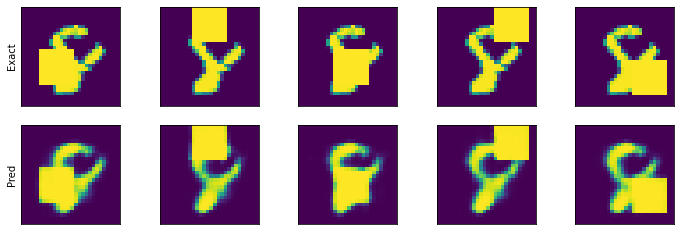

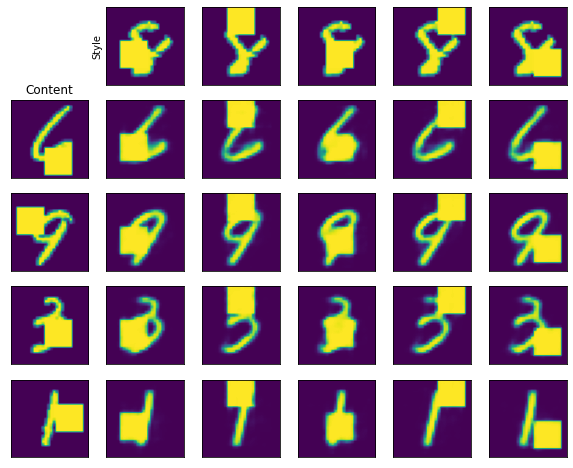

	mean loss    = 447.463
	mse          = 2.496e+02
	KL           = 2.967e+02
	KL           = 2.596e+01
	dec_var      = 1.000e+00
epoch = 49.44s
Start of epoch 96
	mean loss    = 447.457
	mse          = 2.493e+02
	KL           = 2.968e+02
	KL           = 2.597e+01
	dec_var      = 1.000e+00
epoch = 48.38s
Start of epoch 97
	mean loss    = 447.379
	mse          = 2.493e+02
	KL           = 2.968e+02
	KL           = 2.596e+01
	dec_var      = 1.000e+00
epoch = 48.55s
Start of epoch 98
	mean loss    = 447.117
	mse          = 2.488e+02
	KL           = 2.968e+02
	KL           = 2.597e+01
	dec_var      = 1.000e+00
epoch = 48.78s
Start of epoch 99
	mean loss    = 447.077
	mse          = 2.487e+02
	KL           = 2.967e+02
	KL           = 2.598e+01
	dec_var      = 1.000e+00
epoch = 48.33s
Start of epoch 100
=== TRN ===


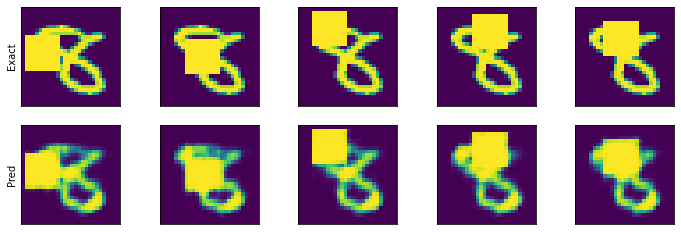

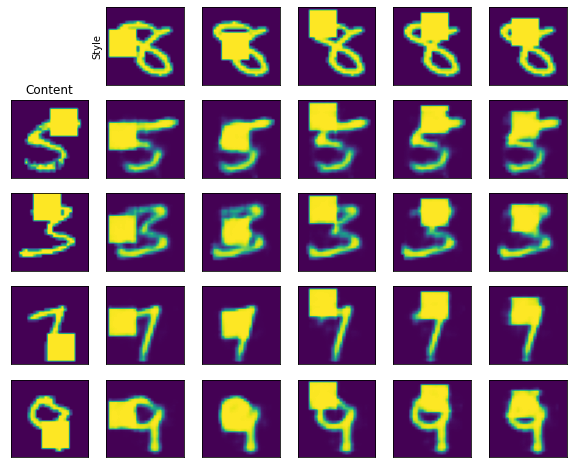

	mean loss    = 446.862
	mse          = 2.484e+02
	KL           = 2.967e+02
	KL           = 2.599e+01
	dec_var      = 1.000e+00
epoch = 50.39s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
    
        """ plot decoding of replicates """
        pred = mlvae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = mlvae.content_encode(trn_batch).numpy()
        style_code = mlvae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = mlvae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
    
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    print('\tmse          = %.3e' % trn_mse_metric.result().numpy())
    print('\tKL           = %.3e' % trn_sty_KL_metric.result().numpy())
    print('\tKL           = %.3e' % trn_cnt_KL_metric.result().numpy())
    print('\tdec_var      = %.3e' % mlvae.decoder.dec_var.numpy())
    trn_loss_metric.reset_states()
    trn_mse_metric.reset_states()
    trn_sty_KL_metric.reset_states()
    trn_cnt_KL_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [8]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
mlvae.save_weights('mlvae-masked-mnist.h5')

### Load Model

In [8]:
# define model
style_dim = 20
content_dim = 20
data_dim = 28*28
ninstances = NUM_INSTANCES

mlvae = MLVAE(data_dim, style_dim, content_dim, dec_var_model='fixed')

# call with dummy input to initialize dimensions
mlvae(np.zeros((1,NUM_INSTANCES,28*28), dtype='float32'))

mlvae.load_weights('mlvae-masked-mnist.h5')

0


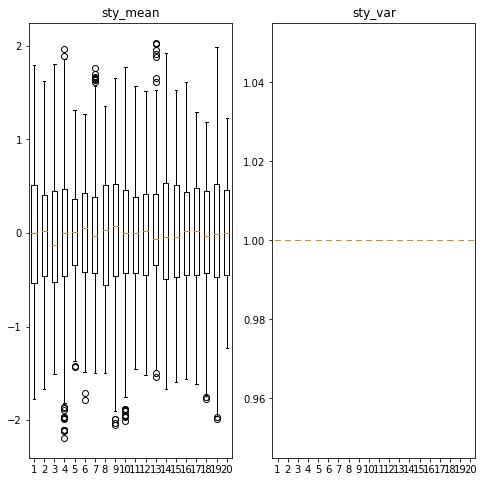

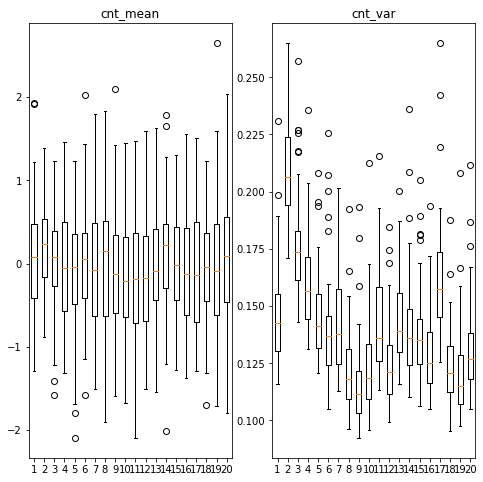

1


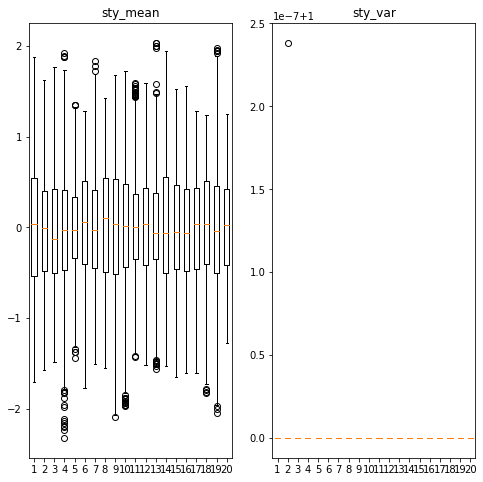

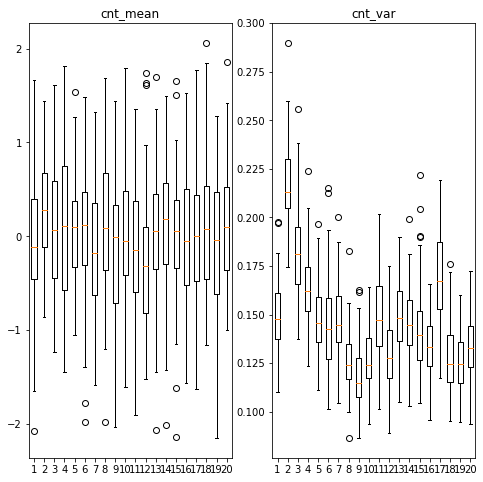

2


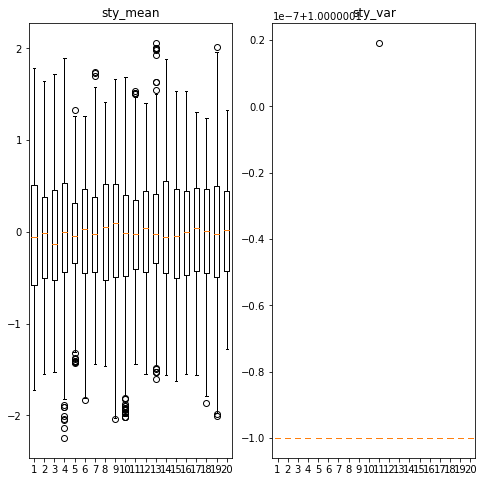

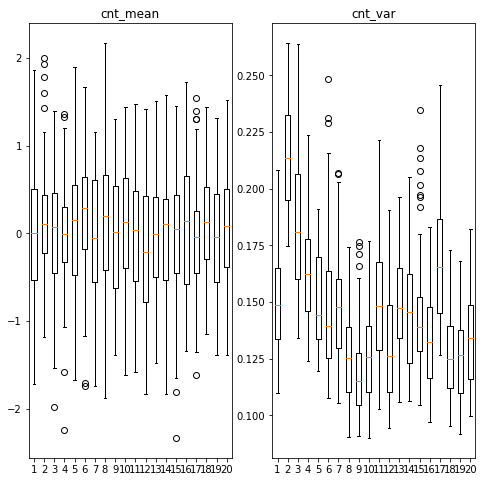

3


In [44]:
# check style variance and plot 
for kk, trn_batch in enumerate(trn_dataset):
    print(kk)
    if kk > 2:
        break
        
    """ compute style encoding """
    sty_mean, sty_log_var = mlvae.style_encoder(trn_batch)
    sty_mean = sty_mean.numpy()
    sty_log_var = sty_log_var.numpy()
    
    cnt_mean, cnt_log_var = mlvae.content_encoder(trn_batch)
    
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.boxplot(sty_mean.reshape(-1, 20))
    plt.title('sty_mean')
    plt.subplot(122)
    plt.boxplot(np.exp(sty_log_var.reshape(-1, 20)))
    plt.title('sty_var')
    plt.show()
    
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.boxplot(np.squeeze(cnt_mean))
    plt.title('cnt_mean')
    plt.subplot(122)
    plt.boxplot(np.exp(np.squeeze(cnt_log_var)))
    plt.title('cnt_var')
    plt.show()
    
#     print(type(sty_log_var))
#     print(sty_log_var.shape)    


In [43]:
print(cnt_mean.shape)
print(cnt_log_var.shape)

(64, 1, 20)
(64, 1, 20)


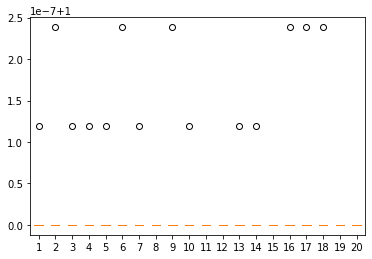

In [28]:
plt.figure()
plt.boxplot(np.exp(sty_log_var.reshape(-1, 20)))
plt.show()

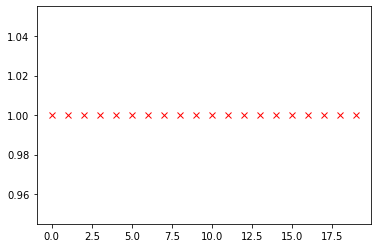

In [34]:
plt.figure()
plt.plot(np.mean(np.exp(sty_log_var).reshape(-1,20), axis=0), 'rx')
plt.show()